In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import pdb
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.style as style

% matplotlib inline
style.use('seaborn-whitegrid')
warnings.filterwarnings(action='once')

UsageError: Line magic function `%` not found.


## Prepare image data for training

Currently processing Open palm data.
Currently processing Closed palm data.
Currently processing L data.
Currently processing Fist data.
Currently processing Thumbs up data.
X_data shape: (2500, 144, 256, 3)
y_data shape: (2500, 5)


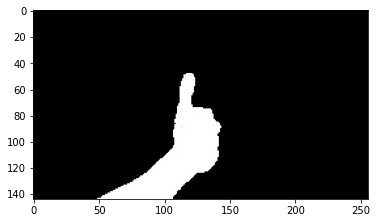

In [3]:
from keras.utils import to_categorical

def process_image(path):
    """Opens image and converts to array."""
    img = Image.open(path)
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    """Converts each binary frame with dimensions MxNx1 to MxNx3 to mimic RGB pixel count. This is necessary since the VGG-16 model expects arrays with these dimensions."""
    X_data = np.array(X_data, dtype = 'float32')
    X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    return X_data, y_data

def get_gest_data(relative_paths, cat_num, max_count):
    """Uses image directory path and gesture category number to generate X_data and y_data arrays for particular gesture."""
    count_per_dir_dict = {}
    num_dirs_in_excess = 0
    count_remaining = max_count
    X_data = []
    for path in relative_paths:
        for directory, subdirectories, files in os.walk(path):
            num_files = len(files)
        count_per_dir_dict[path] = num_files
        if num_files <= max_count / len(dirs):
            count_remaining -= len(files)
        else:
            num_dirs_in_excess += 1
    for path in relative_paths:
        X_data_temp = []
        for directory, subdirectories, files in os.walk(path):
            for file in files:
                file_path = os.path.join(directory, file)
                X_data_temp.append(process_image(file_path))
        # if appropriate amount, process X_data as usual
        if count_per_dir_dict[path] <= max_count / len(dirs):
            X_data.extend(X_data_temp) 
        else: 
            count_for_dir = int(np.ceil(count_remaining/num_dirs_in_excess))
            random_indices = np.random.choice(len(X_data_temp), size=count_for_dir, replace=False)
            X_data_temp = [X_data_temp[i] for i in random_indices]
            X_data.extend(X_data_temp) 
    y_data = [cat_num for i in range(len(X_data))]
    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

# gesture image directories
op_input_dirs = ['2021_01_29_T19_16_17_open_palm_without_glove//pure_data']
cp_input_dirs = ['2021_02_07_T22_01_32_closed_palm//good_data']
l_input_dirs = ['2021_02_07_T22_02_36_L//good_data']
fi_input_dirs = ['2021_02_01_T14_28_23_fist//pure_data']
tu_input_dirs = ['2021_02_07_T22_03_02_thumbs_up//good_data//front', '2021_02_07_T22_03_02_thumbs_up//good_data//side']

# dictionary mapping gesture abbreviation to category number, gesture name, and gesture directory
gestures_dict = {
    'op': [0, 'Open palm', op_input_dirs],
    'cp': [1, 'Closed palm', cp_input_dirs],
    'l_': [2, 'L', l_input_dirs],
    'fi': [3, 'Fist', fi_input_dirs],
    'tu': [4, 'Thumbs up', tu_input_dirs],
    }

# Process image datasets into arrays x_data (contains array for each frame) and y_data (contains gesture label)
max_count = 500    # number of images per gesture. This number of based off of least-frequenty occurring gesture in dataset
try:
    del X_data, y_data, X_data_prev, y_data_prev
except:
    pass
X_data = []
y_data = []
for key in list(gestures_dict.keys()):
    # Get x_data y_data for individual gesture
    cat_num = gestures_dict[key][0]
    name = gestures_dict[key][1]
    dirs = gestures_dict[key][2]
    print(f'Currently processing {name} data.')
    X_data_gest, y_data_gest = get_gest_data(dirs, cat_num, max_count)

    # concatenate data for each gesture into X_data and y_data arrays
    try:
        X_data = np.concatenate((X_data_gest, X_data), axis=0)
        y_data = np.concatenate((y_data_gest, y_data), axis=0)
    except:
        X_data = X_data_gest
        y_data = y_data_gest

# converts gesture names to numbers 
y_data = to_categorical(y_data)

# show results
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')
plt.imshow(X_data[0])

### Generate augmented images to improve model training results

In [4]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import math
import cv2
import os

def rotate(frame):
    """Generate rotated versions of image."""

    # flip image
    frame_flipped = tf.image.rot90(frame)
    frame_flipped = tf.image.rot90(frame_flipped)
    frame_flipped = np.array(frame_flipped)
    frame_flipped = cv2.cvtColor(frame_flipped, cv2.COLOR_BGR2GRAY)

    # mirror image 
    datagen = ImageDataGenerator(horizontal_flip=True)
    frame_ext = frame.reshape((1,) + frame.shape) 
    for frame_mirrored in datagen.flow(frame_ext, batch_size=1):
        frame_mirrored = frame_mirrored.reshape((144,256,3))

        # flip mirrored image
        frame_mirrored_flipped = tf.image.rot90(frame_mirrored)
        frame_mirrored_flipped = tf.image.rot90(frame_mirrored_flipped)
        frame_mirrored_flipped = np.array(frame_mirrored_flipped)
        frame_mirrored_flipped = cv2.cvtColor(frame_mirrored_flipped, cv2.COLOR_BGR2GRAY)

        # mirrored image
        frame_mirrored = cv2.cvtColor(frame_mirrored, cv2.COLOR_BGR2GRAY)
        break

    # package results in dictionary
    rotated_frames = []
    rotated_frames.append(frame_flipped)
    rotated_frames.append(frame_mirrored)
    rotated_frames.append(frame_mirrored_flipped)
    return rotated_frames

X_data_rot = []
y_data_rot = []
for i in range(len(X_data[0:10])):
    image = X_data[i]
    rotated_frames = rotate(image)
    X_data_rot.extend(rotated_frames)
    for j in range(len(rotated_frames)):
        y_data_rot.append(y_data[i])
X_data_rot, y_data_rot = process_data(X_data_rot, y_data_rot)
X_data_all = np.append(X_data, X_data_rot, axis=0)
y_data_all = np.append(y_data, y_data_rot, axis=0)

### Build the VGG Model

In [5]:
import time
import datetime
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from sklearn.model_selection import train_test_split

def create_model(height, width, num_categories):
    """Create new VGG-16 model. Return model."""
    # Fetch base VGG16 model 
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))

    # Add top to model
    base = base_model.output
    flat = Flatten()(base)
    fc1 = Dense(128, activation='relu', name='fc1')(flat)
    fc2 = Dense(128, activation='relu', name='fc2')(fc1)
    fc3 = Dense(128, activation='relu', name='fc3')(fc2)
    drop = Dropout(0.5)(fc3)
    fc4 = Dense(64, activation='relu', name='fc4')(drop)
    out = Dense(num_categories, activation='softmax')(fc4)
    model = Model(inputs=base_model.input, outputs=out)

    # Train top layers only
    for layer in base_model.layers:
        layer.trainable = False

    return model

def build_and_save_model(X_train, y_train, model_dir):
    """Build and save new VGG-16 model using confident predictions from database. Return trained model path and training date."""
    # define callback functions
    model_checkpoint = ModelCheckpoint(filepath=model_dir, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy',
                                min_delta=0,
                                patience=10,
                                verbose=1,
                                mode='auto',
                                restore_best_weights=True)
    # create model
    height = X_train.shape[1]
    width = X_train.shape[2]
    num_categories = y_train.shape[1]
    try: 
        assert X_train.shape[3] == 3
    except AssertionError:
        print(f'[ERROR] Training data has {X_train.shape[3]} color layers. Model requires 3.')
    model = create_model(height, width, num_categories)
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # fit model
    start_time = time.time()
    model.fit(X_train, y_train, epochs=1, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping, model_checkpoint])
    print(f'[INFO] Model training took {time.time() - start_time} seconds with {len(X_train)} data points')

    # save model
    training_date = datetime.datetime.now()
    date = training_date.strftime("%Y-%m-%d_T%H_%M")
    model_name = date + '.h5'
    model_path = os.path.join(model_dir, model_name)
    model.save(model_path)
    
    return model

X_train, X_test, y_train, y_test = train_test_split(X_data_all, y_data_all, test_size=0.2, random_state=12, stratify=y_data_all)
model_dir = os.path.join(os.getcwd(), 'models')
model = build_and_save_model(X_train[0:10], y_train[0:10], model_dir)

1/1 [==============================] - 3s 3s/step - loss: 1.5664 - accuracy: 0.2222 - val_loss: 2.7645 - val_accuracy: 0.0000e+00
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets
[INFO] Model training took 7.358792543411255 seconds with 10 data points


### Evaluate model

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, labels):
    """Evaluate model performance. Return F1-score, evaluation date, evaluation time, predicted values, and true values."""
    start_time = time.time()

    # evaluate model performance on validation data
    all_preds = model.predict(X_test)
    y_pred = np.argmax(all_preds, axis=1).tolist()
    y_true = np.argmax(np.array(y_test), axis=1).tolist()

    # generate and save classification_report
    report = classification_report(y_true, y_pred, target_names=labels, zero_division=0, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # generate and save confusion matrix
    df_confusion_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=labels, index=labels)   

    eval_time = time.time()-start_time
    print(f'[INFO] Model evaluation took {eval_time} seconds with {len(X_train)} data points. Average prediction time = {eval_time/len(X_train)}')
    
    return [df_report.round(3), df_confusion_matrix]

# Compute model classification report and confusion matrix
labels = list(pd.DataFrame(list(gestures_dict.values()))[1])
[class_report, con_matrix] = evaluate_model(model, X_test[0:12], y_test[0:12], labels)
print(class_report)
print(con_matrix)

[INFO] Model evaluation took 1.3340306282043457 seconds with 2024 data points. Average prediction time = 0.0006591060416029376
              precision  recall  f1-score  support
Open palm         0.000   0.000     0.000     2.00
Closed palm       0.000   0.000     0.000     1.00
L                 1.000   0.333     0.500     3.00
Fist              0.000   0.000     0.000     2.00
Thumbs up         0.333   0.500     0.400     4.00
accuracy          0.250   0.250     0.250     0.25
macro avg         0.267   0.167     0.180    12.00
weighted avg      0.361   0.250     0.258    12.00
             Open palm  Closed palm  L  Fist  Thumbs up
Open palm            0            0  0     2          0
Closed palm          0            0  0     0          1
L                    0            0  1     1          1
Fist                 0            0  0     0          2
Thumbs up            0            0  0     2          2


### Predict gesture of sample image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Fist


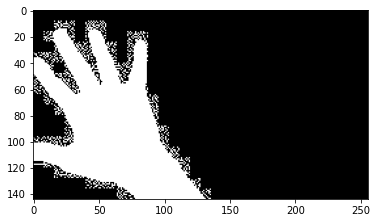

In [9]:
sample_image = os.path.join(os.getcwd(), '2021_01_29_T19_16_17_open_palm_without_glove', 'poor_data', '176.jpg')

def predict_image(path):
    img = Image.open(path)
    img = np.array(img)
    img = np.array(img, dtype = 'float32')
    img = np.stack((img,)*3, axis=-1) # without comma, (X_data) is np.array not tuple
    img.resize((1, 144, 256, 3))
    plt.figure()
    plt.imshow(img[0])
    pred_index = np.argmax(model.predict(img))
    return pred_index

pred_index = predict_image(sample_image)
pred_gest = pd.DataFrame(list(gestures_dict.values())).iloc[pred_index][1]
print(pred_gest)